## Voorspelling watertemperatuur bij reservoirs

### Data analyse

Via eerder geschreven scripts (data.py) kan de data opgehaald worden. Het betreft hier **gemiddelde dagwaarden** voor de periode van 01-01-2015 tot heden. De resultaten worden als een groot csv bestand weggeschreven in data/combined_data.

De kolommen staan voor de volgende locaties van sensormetingen;

| tag | locatie | omschrijving |
|------|------|------|
| 1N305KM01TIT001 |  Nieuwegein Inname - Ruwwater |	Inname Lekkanaal |
| 1N625SW03TT001  |  Nieuwegein Snelfiltratie WRK I (voor snelfiltratie) | WBC voor snelfiltratie |
| 1N625SW02TT001  |  Nieuwegein Snelfiltratie WRK II (voor snelfiltratie) | WBC voor snelfiltratie |
| 1N315KM01TIT001 | Nieuwegein Transport - WRK I Filtraat | WBC na snelfiltratie |
| 1N315KM02TIT003 | Nieuwegein Transport - WRK II Filtraat | WBC na snelfiltratie |
| | | |
| 1Q325TB03TT151  | MIS Transport - WRK water Nieuwerkerkerstraat Lijnden | aftakking WRK II naar Havengebied |
| 1D325TA01TT001  | MIS Transport - WRK water Vogelenzang | Precieze locatie onbekend |
| T-WRK-Schiphol_STUW12 | MIS Transport WRK water stuw 12 | AWD voor infiltratie |
| | | |
| 1L635KM05TT002  | LDN Hardheidsreductie - onthard water afvoer West | Leiduin na ontharding |
| 1L635KM05TT001  | LDN Hardheidsreductie - onthard water afvoer Oost | Leiduin na ontharding |
| 1L315KM01TT001  | LDN Transport - Leiduin I Drinkwater | Leiduin drinkwater af pomp |
| | | |
| 3H325WT01TT001  | HLW Distributie - Haarlemmerweg Drinkwater | Pompstation Haarlemmerweg |
| 3A415DR01_Temp1 | AVW Drinkwaterreservoir 5 Ingaand HV085 | Pompstation Amstelveenseweg voor reservoir 5 |
| 3A415DR01_Temp2 | AVW Drinkwaterreservoir 5 Ingaand HV086 | Pompstation Amstelveenseweg voor reservoir 5 |
| 3A415DR01_Temp3 | AVW Drinkwaterreservoir 5 Uitgaand HV054 | Pompstation Amstelveenseweg na reservoir 5 |
| 3A415DR01_Temp4 | AVW Drinkwaterreservoir 1 Ingaand HV061 | Pompstation Amstelveenseweg voor reservoir 1 |
| 3A415DR01_Temp5 | AVW Drinkwaterreservoir 1 Ingaand HV062 | Pompstation Amstelveenseweg voor reservoir 1 |
| 3A415DR01_Temp6 | AVW Drinkwaterreservoir 1 Uitgaand HV038 | Pompstation Amstelveenseweg na reservoir 1 |

We lezen eerst de gemiddelde data per dag in om te kijken hoe de data eruit ziet.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import data
import datetime

%matplotlib inline

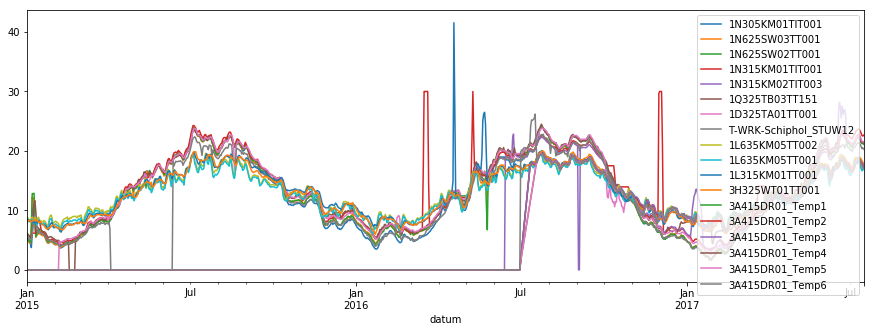

In [2]:
dateparser = lambda x: pd.datetime.strptime(x, '%d-%m-%Y %H:%M:%S')
df = pd.read_csv('data/combined_data.csv', parse_dates=[1], date_parser=dateparser)
df = df.reset_index()
_ = df.plot(x='datum', y=data.TAGS[:], figsize=(15,5))

#### Prophet library toepassen

Een eerste mogelijkheid is het kijken naar de toepassing van een timeseries prediction algoritme dat verder geen afhankelijkheden bekijkt. We gebruiken hiervoor Prophet https://github.com/facebookincubator/prophet waar in het testproject van het Waternet datalab https://github.com/waternet/datalab_alg_prophet_test al code voor is geschreven.

We beginnen met de gewone toepassing van prophet en zoek een geschikte data serie aan de output kant.

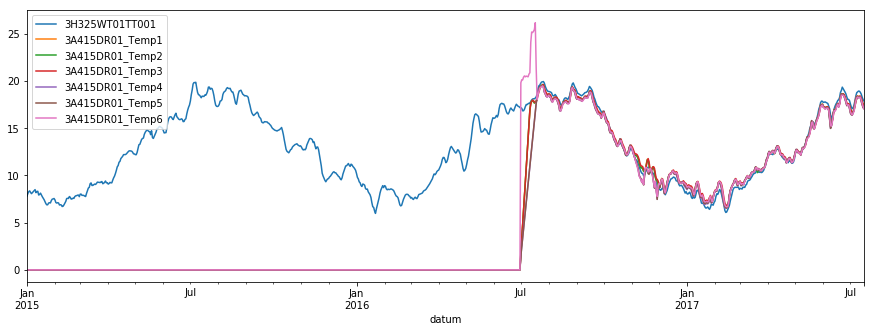

In [3]:
_ = df.plot(x='datum', y=data.TAGS_OUTPUT, figsize=(15,5))

De langst lopende temperatuurmeting is die van de Haarlemmerweg, deze gebruiken we voor de predictie via prophet.

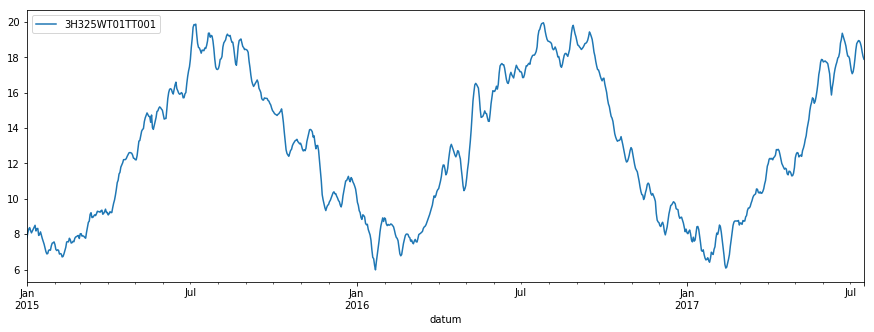

In [4]:
_ = df.plot(x='datum', y=['3H325WT01TT001'], figsize=(15,5))

We maken de data klaar voor Prophet waarbij een 'ds' kolom nodig is met datetimes en een 'y' kolom met outputs. We willen de data kunnen controleren dus we trainen met gegevens tot een x aantal dagen voor het laatste datapunt.

#### Aanname / aanpassing
We gebruiken het logaritme van de waarnemingen om ervoor te zorgen dat de extreme wisselingen wat minder effect hebben.

In [5]:
VOORSPELLINGSPERIODE = 10 #dagen

df_hw = pd.DataFrame()
df_hw['ds'] = df['datum'][:-VOORSPELLINGSPERIODE]
df_hw['y'] = np.log(df['3H325WT01TT001'][:-VOORSPELLINGSPERIODE])

De volgende stap is om het model te trainen.

In [6]:
from fbprophet import Prophet
model = Prophet()
model.fit(df_hw)

En nu kunnen we een voorspelling doen. Laten we beginnen met een week vooruit te kijken.

In [7]:
future = model.make_future_dataframe(periods=VOORSPELLINGSPERIODE)

In [8]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
923,2017-07-12,2.961070,2.883976,3.040955
924,2017-07-13,2.964188,2.887452,3.039681
925,2017-07-14,2.968162,2.890238,3.043634
926,2017-07-15,2.974281,2.895951,3.055886
927,2017-07-16,2.980120,2.899032,3.058352


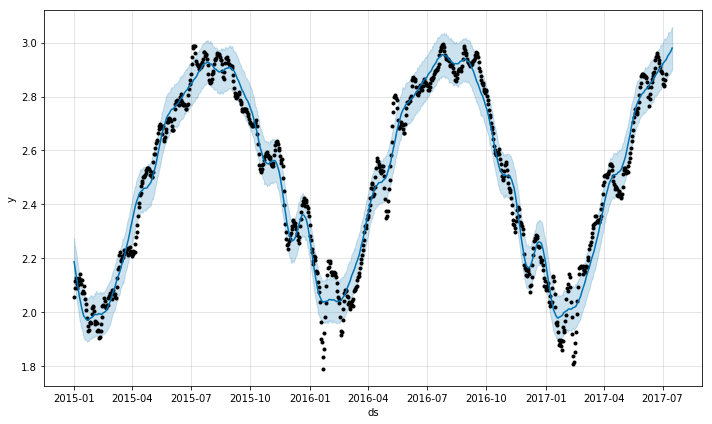

In [9]:
_ = model.plot(forecast)

Laten we eens kijken naar de voorspelde tegen de werkelijke waarde

In [10]:
X = df['datum'][-VOORSPELLINGSPERIODE:]
y_test = df['3H325WT01TT001'][-VOORSPELLINGSPERIODE:]
y_pred = np.exp(forecast['yhat'][-VOORSPELLINGSPERIODE:])
y_pred_lower = np.exp(forecast['yhat_lower'][-VOORSPELLINGSPERIODE:])
y_pred_upper = np.exp(forecast['yhat_upper'][-VOORSPELLINGSPERIODE:])

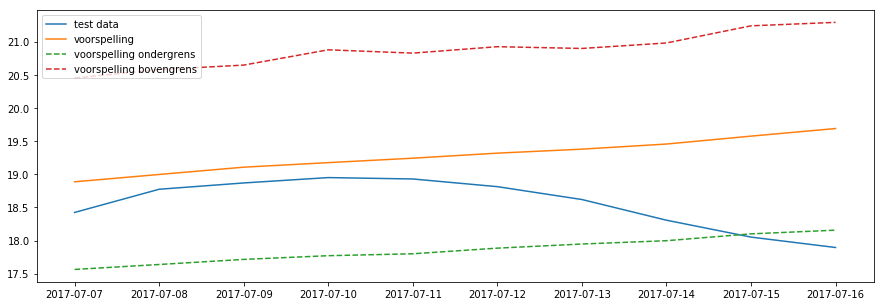

In [11]:
plt.figure(figsize=(15,5))
plt.plot(X, y_test, label='test data')
plt.plot(X, y_pred, label='voorspelling')
plt.plot(X, y_pred_lower, '--', label='voorspelling ondergrens')
plt.plot(X, y_pred_upper, '--', label='voorspelling bovengrens')
plt.legend()

Op zich niet heel slecht maar dit is maar een enkele test op 1 tijdstip. We gaan nu de volgende testmethode toepassen;

We trainen het model met 1 jaar data, daarna simuleren we tijdintervallen van 1 dag waarbinnen het model opnieuw getrained wordt. Met dit aangepaste model doen we een nieuwe voorspelling. Het model moet daarmee slimmer worden en we kunnen over een langere periode zien hoe goed of slecht de voorspellingen zijn.

Uitgangspunt is om een voorspelling te doen van X dagen.

We gebruiken de eerder door het datalab gemaakte testsuite

In [12]:
#importing the pims module requires adding the following module to the python path
import sys
sys.path.append("/home/waternet/programmeren/python/datalab/datalab_alg_prophet_test")
import tester

predicting for [0:365>
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
predicting for [0:415>
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
predicting for [0:465>
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
predicting for [0:515>
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
predicting for [0:565>
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
predicting for [0:615>
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
predicting for [0:665>
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
predicting for [0:715>
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
predicting for [0:765>
predicting for [0:815>
predicting for [0:865>


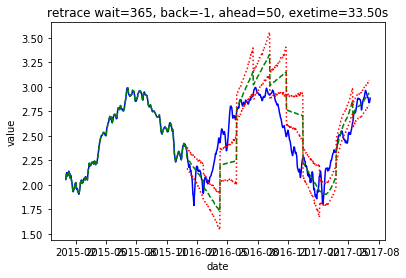

KeyError: '[  7.804        8.087        8.294        8.37         8.204        8.074\n   8.178        8.273        8.396        8.503        8.181        8.308\n   8.327        7.93         7.989        8.13         7.934        7.752\n   7.597        7.436        7.233        7.013        6.886        6.901\n   7.088        7.106        7.093        7.34         7.494        7.515\n   7.564        7.414        7.139        7.073        7.117        7.088\n   6.875        6.904        6.879        6.713        6.741        6.888\n   7.069        7.253        7.558        7.581        7.563        7.77\n   7.681        7.498        7.523        7.594        7.572        7.767\n   7.845        7.861        7.913        7.924        7.757        8.021\n   8.028        7.89         7.904        7.883        7.814        7.771\n   8.109        8.384        8.666        8.74         9.126        9.214\n   8.942        8.951        9.022        9.095        9.051        9.155\n   9.297        9.278        9.275        9.243        9.324        9.359\n   9.126        9.174        9.278        9.416        9.219        9.234\n   9.087        9.155        9.272        9.218        9.226        9.506\n   9.749        9.934       10.211       10.536       10.914       11.054\n  11.405       11.494       11.796       11.918       12.033       12.213\n  12.219       12.216       12.278       12.4         12.504       12.6\n  12.618       12.602       12.578       12.473       12.298       12.284\n  12.213       12.203       12.442       12.878       13.267       13.296\n  13.571       13.821       13.924       13.967       14.365       14.579\n  14.719       14.857       14.755       14.662       14.65        14.327\n  14.739       14.025       13.928       14.152       14.397       14.601\n  14.938       14.975       15.119       15.2         15.15        15.072\n  15.009       14.756       14.508       14.536       14.544       15.109\n  15.677       16.016       16.193       16.226       16.191       16.02\n  15.926       16.177       16.435       16.597       16.234       16.118\n  15.981       15.917       15.935       16.007       15.956       15.711\n  15.721       15.937       16.01        16.511       16.92        17.233\n  17.465       17.889       18.553       19.06        19.696       19.852\n  19.847       19.877       19.296       18.791       18.56        18.528\n  18.396       18.237       18.409       18.396       18.376       18.529\n  18.501       18.67        18.925       19.368       19.368       19.138\n  19.239       19.207       18.932       18.488       17.906       17.466\n  17.333       17.313       17.363       17.541       17.887       17.916\n  18.048       18.582       18.818       18.904       18.989       19.212\n  19.314       19.231       19.216       19.24        19.019       18.852\n  18.852       18.538       18.086       17.668       17.551       18.036\n  18.63        18.942       18.996       19.04        18.818       18.619\n  18.55        18.439       18.458       18.436       18.397       18.283\n  17.785       17.425       16.99        16.656       16.478       16.356\n  16.439       16.539       16.623       16.72        16.58        16.249\n  16.139       16.012       15.673       15.594       15.584       15.706\n  15.687       15.68        15.676       15.564       15.522       15.396\n  15.31        15.13        14.986       14.923       14.834       14.782\n  14.757       14.714       14.78        14.814       14.894       14.961\n  15.086       14.753       14.325       13.771       13.29        12.772\n  12.563       12.477       12.405       12.58        12.736       12.796\n  13.007       13.12        13.201       13.284       13.315       13.365\n  13.238       13.18        13.108       13.147       13.016       12.815\n  12.707       12.773       12.719       12.853       13.234       13.466\n  13.711       13.907       13.925       13.879       13.791       13.492\n  13.563       13.161       12.831       13.01        13.017       12.728\n  12.153       11.572       11.005       10.235        9.943        9.703\n   9.489        9.335        9.511        9.633        9.673        9.833\n   9.916       10.053       10.175       10.339       10.396       10.291\n  10.291       10.149       10.045        9.904        9.839        9.647\n   9.542        9.747       10.165       10.444       10.706       11.011\n  11.031       11.142       11.271       11.069       10.967       11.201\n  11.128       10.955       10.854       10.717       10.549        9.67936492\n   9.6652651    9.64174127   9.59137395   9.52770708   9.46133872\n   9.41290118   9.37252896   9.35887611   9.33609799   9.28732731\n   9.22567868   9.1614142    9.11451213   9.07541971   9.06219965\n   9.0401436    8.99291895   8.93322458   8.87099729   8.82558201\n   8.78772882   8.77492784   8.75357096   8.70784334   8.65004128\n   8.58978659   8.54581098   8.50915774   8.49676255   8.47608268\n   8.43180463   8.3758349    8.31749028   8.2749087    8.23941736\n   8.2274151    8.20739079   8.16451635   8.11032085   8.05382577\n   8.01259402   7.97822776   7.96660596   7.94721642   7.9057011\n   7.85322361   7.79851942   7.75859472   7.72531787   7.26808339\n   7.24400332   7.19937388   7.14728587   7.09129207   7.04284364\n   7.01459005   7.01111591   6.9878872    6.94483567   6.89458926\n   6.84057516   6.79383965   6.76658498   6.76323367   6.74082623\n   6.6992968    6.65082688   6.59872249   6.55363934   6.52734828\n   6.52411545   6.50250024   6.46243911   6.41568288   6.36542066\n   6.32193146   6.29656993   6.29345141   6.27260041   6.23395567\n   6.18885253   6.14036737   6.09841575   6.0739509    6.07094263\n   6.05082883   6.0135504    5.97004191   5.92327097   5.88280257\n   5.85920269   5.85630078   5.83689812   5.80093769   5.75896747\n   5.71385014   5.67481253   5.65204704   5.64924773   9.05404464\n   9.05528397   9.05261334   9.05206222   9.05308109   9.06722092\n   9.10815132   9.10940718   9.11065409   9.10796712   9.10741264\n   9.10843774   9.12266403   9.16384471   9.16510824   9.16636278\n   9.16365938   9.16310151   9.16413287   9.17844615   9.21987864\n   9.2211499    9.22241211   9.21969218   9.2191309    9.22016857\n   9.23456937   9.2762552    9.27753423   9.27880416   9.2760676\n   9.27550288   9.2765469    9.29103576   9.33297648   9.33426334\n   9.33554103   9.33278774   9.33221957   9.33326997   9.34784742\n   9.3900446    9.39133932   9.39262483   9.3898547    9.38928306\n   9.39033988   9.40500647   9.44746167   9.44876431  16.14463695\n  16.23793804  16.33060956  16.42794576  16.55429727  16.73490896\n  16.90810921  17.02988445  17.12830145  17.22605436  17.32872773\n  17.46200739  17.65252243  17.83521964  17.9636721   18.06748553\n  18.17059846  18.27890164  18.41948933  18.62045075  18.81316567\n  18.94866147  19.05816723  19.16693407  19.28117577  19.42947221\n  19.6414528   19.84473472  19.98766007  20.10317028  20.21790106\n  20.33840689  20.49483476  20.71843874  20.93286707  21.08362935\n  21.20547324  21.32649498  21.45360842  21.61861359  21.85447828\n  22.08066422  22.23969313  22.36821801  22.49587565  22.62995901\n  22.80401179  23.05280949  23.29139772  23.45914655  20.52034344\n  20.60895677  20.70226871  20.8320403   21.0257409   21.20388036\n  21.31571631  21.44580392  21.53841368  21.63593395  21.7715582\n  21.97399463  22.16016812  22.27704783  22.41300235  22.50978877\n  22.61170718  22.75344804  22.96501428  23.15958414  23.28173508\n  23.4238211   23.52497256  23.63148745  23.77962077  24.00072858\n  24.20407347  24.33173337  24.48022743  24.58594078  24.69725946\n  24.85207354  25.08315324  25.29566891  25.42908624  25.58427732\n  25.69475831  25.81109743  25.97289357  26.21439488  26.43649494\n  26.57592934  26.73811949  26.85358313  26.9751691   27.14426219\n  27.39665513  27.62877183  27.77449467  27.94399954  20.37395487\n  20.39978846  20.45340571  20.56590782  20.66096984  20.69607284\n  20.72511033  20.77585632  20.80219951  20.85687443  20.97159578\n  21.06853302  21.10432847  21.13393876  21.18568577  21.21254862\n  21.26830207  21.38528644  21.48413588  21.52063744  21.55083184\n  21.60359962  21.63099237  21.68784562  21.80713766  21.90793703\n  21.94515862  21.97594864  22.02975734  22.05769044  22.11566519\n  22.23731041  22.34009817  22.37805401  22.4094514   22.46432154\n  22.49280566  22.55192403  22.67596886  22.78078423  22.8194888\n  22.85150554  22.90745806  22.93650406  22.99678862  23.12328038\n  23.23016337  23.26963143  23.30227974  23.35933599  15.85074993\n  15.82742331  15.84237056  15.84178341  15.80263381  15.75761416\n  15.71163784  15.71734884  15.69421854  15.70903999  15.70845778\n  15.66963767  15.62499691  15.57940752  15.58507046  15.56213482\n  15.57683154  15.57625423  15.53776083  15.49349577  15.44829006\n  15.45390534  15.43116274  15.44573576  15.44516331  15.40699388\n  15.36310135  15.3182761   15.32384412  15.30129292  15.3157433\n  15.31517567  15.27732747  15.23380435  15.18935635  15.19487751\n  15.1725161   15.18684486  15.18628201  15.14875234  15.10559551\n  15.0615216   15.06699629  15.04482307  15.05903124  15.05847313\n  15.02125931  14.97846569  14.93476271  14.94019132   9.24346059\n   9.21481108   9.18238259   9.11845807   9.05029196   8.98548736\n   8.92711292   8.87446907   8.84696323   8.81582925   8.75445655\n   8.68901158   8.62679392   8.57074975   8.52020739   8.49379956\n   8.46390843   8.40498568   8.34215321   8.28241924   8.2286123\n   8.18008756   8.15473391   8.12603601   8.0694654    8.00914116\n   7.95179172   7.90013271   7.85354504   7.82920348   7.80165118\n   7.74733883   7.68942268   7.63436258   7.58476576   7.54003783\n   7.51666797   7.49021553   7.43807128   7.3824671    7.32960496\n   7.28198801   7.23904558   7.21660863   7.19121215   7.14114946\n   7.08776495   7.03701302   6.9912969    6.95006869   6.9213089\n   6.93084065   6.91254554   6.89294894   6.87576561   6.84972876\n   6.83530067   6.83006304   6.82755064   6.80053125   6.77547195\n   6.75620221   6.73172074   6.72210649   6.72488567   6.73352668\n   6.72087076   6.71263719   6.71224815   6.70836399   6.7205648\n   6.74606922   6.77799477   6.78855535   6.80321396   6.82515723\n   6.84260983   6.87534509   6.92048789   6.97096471   6.99813826\n   7.02819562   7.06455767   7.09520483   7.14084408   7.19878844\n   7.26197735   7.30082262   7.34284386   7.39188709   7.43561533\n   7.49592873   7.57023084   7.65125226   7.70782765   7.76888035\n   7.83840464   7.90316353   7.98620556   8.08457535  10.58790685\n  10.70582429  10.8263473   10.9601323   11.08453394  11.22854739\n  11.41055649  11.58763094  11.73183771  11.87422032  12.025843\n  12.16135774  12.31221329  12.49830416  12.67246885  12.80437239\n  12.92839943  13.0571335   13.16377005  13.2832771   13.43787451\n  13.57772499  13.671729    13.75812644  13.8515194   13.92463525\n  14.01559961  14.14864129  14.27199332  14.35376361  14.43468069\n  14.53031464  14.61209273  14.71985135  14.87876072  15.03396552\n  15.15105217  15.27192852  15.4120397   15.53993951  15.69671776\n  15.90817551  16.11456734  16.27751048  16.4405262   16.61906519\n  16.77815323  16.96119247  17.19534773  17.41543746  14.91435987\n  15.06246501  15.2116761   15.33746893  15.47160463  15.63715055\n  15.78750065  15.89491858  15.9755257   16.05371903  16.10550054\n  16.1661836   16.2613235   16.34382226  16.38676663  16.40851014\n  16.43533729  16.44353875  16.46979681  16.54030523  16.60711939\n  16.64277192  16.66550572  16.70134357  16.72532976  16.77375975\n  16.87232244  16.97108848  17.0407105   17.0984903   17.16989665\n  17.22816403  17.30963597  17.44007785  17.5672519   17.66009715\n  17.736008    17.8211386   17.88765563  17.97340776  18.10542488\n  18.22986454  18.31504846  18.37972234  18.45173972  18.50305247\n  18.57360029  18.69197173  18.80317967  18.87519961] not in index'

In [14]:
interval_1 = tester.retrace(df_hw, i_wait=365, i_lookback=-1, i_lookahead=50) #VOORSPELLINGSPERIODE)
interval_1.to_csv('interval_1.csv')
y = np.exp(interval_1['yhat'])
interval_1.plot(x=interval_1['ds'], y=y)